In [17]:
from sklearn.ensemble import RandomForestRegressor
## Install XGBOOST in the Anaconda envo using:  conda install -c conda-forge xgboost 
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math
from statistics import mean
import seaborn as sns 
%matplotlib inline 
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import pearsonr
from sklearn import tree, linear_model
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from timeit import default_timer
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d


In [18]:
# Read the data into a data frame
supData = pd.read_csv("train.csv", delimiter=",")
print("length of supData: ", len(supData))
# Check the number of features in the data set
print("features in the data set: ", len(supData.columns))
# Check the data types
print("data type: ", supData.dtypes.unique())

# Check any number of columns with NaN
print("Check NaN in coloumn : ", supData.isnull().any().sum(), ' / ', len(supData.columns))
# Check any number of data points with NaN
print("Check NaN in rows : ", supData.isnull().any(axis=1).sum(), ' / ', len(supData))


# Read the unique_m.csv data
supData_ele = pd.read_csv("unique_m.csv", delimiter=",")
supData_ele_ = supData_ele[['Cu','O','Fe','material']] # select columns contain Cu, O, Fe

bigdata =pd.concat([supData, supData_ele_], axis=1) # To merge across columns
print("length of bigdata: ", len(bigdata))
#bigdata.to_csv('file_name.csv', sep='\t') # To save the output data to a .csv file

supData_ele_Cu = bigdata.loc[~bigdata['Cu'].isin(['0'])] # Delete 0 for the Cu column
supData_ele_O = bigdata.loc[~bigdata['O'].isin(['0'])] # Delete 0 for the O column
supData_ele_Fe = bigdata.loc[~bigdata['Fe'].isin(['0'])] # Delete 0 for the Fe column


print("length Cu: ", len(supData_ele_Cu), "length of O: ", len(supData_ele_O), "length of Fe", len(supData_ele_Fe))
#supData_ele_Cu.to_csv('file_name_Cu.csv', sep='\t') # To save the output data to a .csv file
#supData_ele_O.to_csv('file_name_O.csv', sep='\t') # To save the output data to a .csv file
#supData_ele_Fe.to_csv('file_name_Fe.csv', sep='\t') # To save the output data to a .csv file

length of supData:  21263
features in the data set:  82
data type:  [dtype('int64') dtype('float64')]
Check NaN in coloumn :  0  /  82
Check NaN in rows :  0  /  21263
length of bigdata:  21263
length Cu:  10838 length of O:  11964 length of Fe 2339


In [19]:
def load_Data_PCA(Data):
    myData = pd.DataFrame(Data)
    #--------------
    # Extract features and target data
    target = myData.iloc[:,-5] # get the 5th column from the last of the data frame
    #print("target", target.shape)
    features = myData.drop(['critical_temp', 'O', 'Fe','material'], axis=1)
    #print("features", features.shape)
    features_normalized = preprocessing.normalize(features, norm='l2', axis=1, copy=True, return_norm=False)
    X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.33) #, random_state=42
    #return X_train, X_test, y_train, y_test, features, target #return already normalized features.
    
    pca = PCA(n_components=30) # to get the 99% of the variance in the data
    pca.fit(features_normalized) # fit the normalized feature space
    X_train_pca = pca.transform(X_train) # apply the tranform to the both training and the test set
    #print("X_train_pca", X_train_pca.shape)
    X_test_pca = pca.transform(X_test)
    #print("X_test_pca", X_test_pca.shape)
    variance = pca.explained_variance_ratio_
    num_pca = pca.n_components_

    return X_train_pca, X_test_pca, y_train, y_test, num_pca, variance, features, target


def Grid_Search_CV_RFR(X_train, y_train):

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10, 20, 30],
            "criterion"         : ['mse'],
            "max_features"      : ["sqrt"],
            "min_samples_split" : [2,4,8],
            "bootstrap"         : [False, True],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=10)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

def RFR(X_train, X_test, y_train, y_test, best_params):
    estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    return y_test,y_predict

def corr(Data):
    myData = pd.DataFrame(Data)
    features = myData.drop(['critical_temp','Cu', 'O', 'Fe','material'], axis=1).columns.tolist()
    target = myData.iloc[:,-5].name
    #X_train, X_test, y_train, y_test, features, target = load_Data(Data)

    correlations = {}
    for feature in features:
        data_temp = supData[[feature,target]]
        x1 = data_temp[feature].values
        x2 = data_temp[target].values
        key = feature + ' vs ' + target
        correlations[key] = pearsonr(x1,x2)[0]
    data_correlations = pd.DataFrame(correlations, index=['Value']).T
    return data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]
    


In [20]:
a = corr(supData_ele_O)
print(a)

                                                     Value
wtd_std_ThermalConductivity vs critical_temp      0.721271
range_ThermalConductivity vs critical_temp        0.687654
range_atomic_radius vs critical_temp              0.653759
std_ThermalConductivity vs critical_temp          0.653632
wtd_mean_Valence vs critical_temp                -0.632401
wtd_entropy_atomic_mass vs critical_temp          0.626930
wtd_gmean_Valence vs critical_temp               -0.615653
wtd_entropy_atomic_radius vs critical_temp        0.603494
number_of_elements vs critical_temp               0.601069
range_fie vs critical_temp                        0.600790
mean_Valence vs critical_temp                    -0.600085
wtd_std_atomic_radius vs critical_temp            0.599199
entropy_Valence vs critical_temp                  0.598591
wtd_entropy_Valence vs critical_temp              0.589664
wtd_std_fie vs critical_temp                      0.582013
gmean_Valence vs critical_temp                   -0.5730

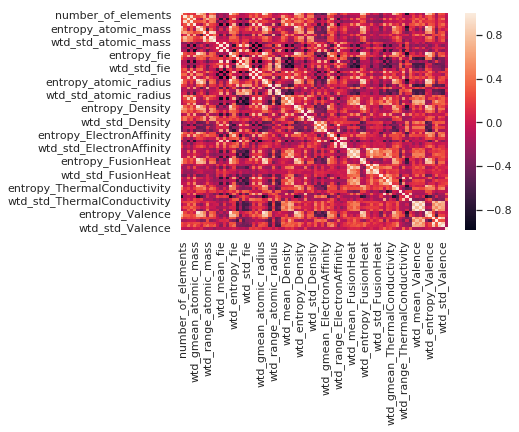

/home/m/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


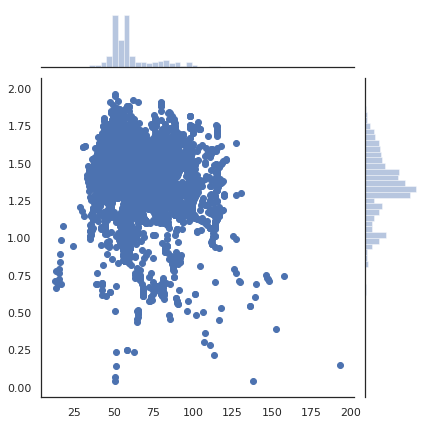

In [21]:
# The relation between the correlations as a heat map
X_train_pca, X_test_pca, y_train, y_test, num_pca, variance, features, target = load_Data_PCA(supData_ele_Cu)

df = pd.DataFrame(features)

corrResults = df.corr()

sns.heatmap(corrResults)

plt.show()

sns.jointplot(df.iloc[:,2].values, df.iloc[:,6].values)

plt.show()


iteration:  0
--------------
Best Score: 0.8147798988809131
Best params: {'bootstrap': False, 'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 30}
pca component 30
iteration:  1
--------------
Best Score: 0.8197535911792028
Best params: {'bootstrap': False, 'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 30}
pca component 30
iteration:  2
--------------
Best Score: 0.8214279837218122
Best params: {'bootstrap': False, 'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 30}
pca component 30
iteration:  3
--------------
Best Score: 0.8159731448509551
Best params: {'bootstrap': False, 'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 30}
pca component 30
iteration:  4
--------------
Best Score: 0.8219994641753603
Best params: {'bootstrap': False, 'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 30}
pca component 30


/home/m/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Average of RMSE:  13.593370951970927
Average of best_score:  0.8187868165616486
Average of R2:  0.8201325270463135
----------------------------


Text(336.9714285714286, 0.5, 'Predicted Critical Temperature (K)')

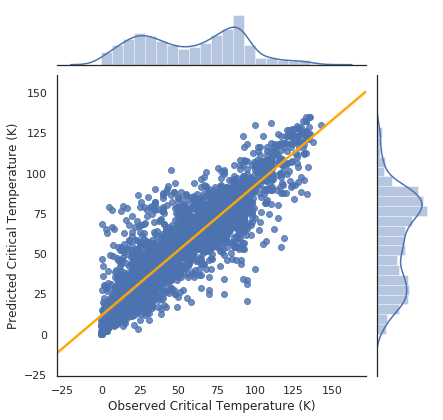

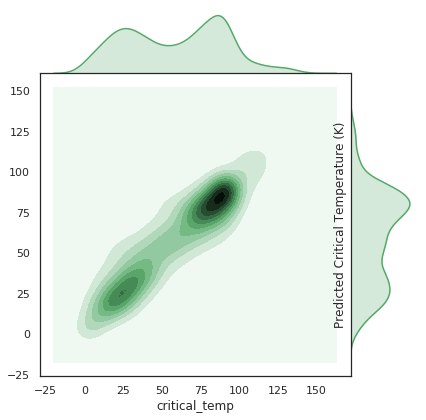

In [16]:
## Oxygen based superconductors
RMSE = []
R2 = []
BEST_SCORE = []
for i in range(5):
    print ("iteration: " , i)
    print ("--------------")
    X_train_pca, X_test_pca, y_train, y_test, num_pca, variance, features, target = load_Data_PCA(supData_ele_Cu)
    best_score, best_params = Grid_Search_CV_RFR(X_train_pca, y_train)
    y_test , y_predict = RFR(X_train_pca, X_test_pca, y_train, y_test, best_params)
    rmse = math.sqrt(np.mean((y_predict - y_test) ** 2))
    r2 = r2_score(y_test,y_predict)
    RMSE.append(rmse)
    R2.append(r2)
    BEST_SCORE.append(best_score)

    print ("Best Score:" ,best_score)
    print ("Best params:",best_params)
    print("pca component", num_pca)
    
sns.set(style="white", color_codes=True)
g = sns.jointplot(y_test, y_predict, kind='reg', joint_kws={'line_kws':{'color':'orange'}})


plt.ylabel('Predicted Critical Temperature (K)', fontsize=12)
plt.xlabel('Observed Critical Temperature (K)', fontsize=12)
print("Average of RMSE: ", mean(RMSE))
print("Average of best_score: ", mean(BEST_SCORE))
print("Average of R2: ", mean(R2))  
print("----------------------------")
gg = sns.jointplot(y_test, y_predict, kind="kde", space=0, color="g")
plt.ylabel('Predicted Critical Temperature (K)', fontsize=12)
###----------------------

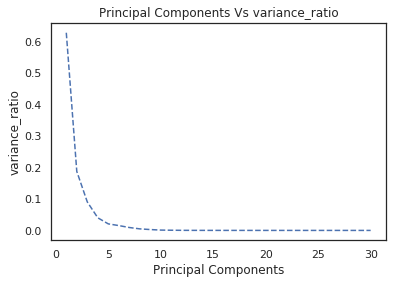

In [22]:
plt.plot(range(1,31), variance, 'b--')
plt.xlabel('Principal Components')
plt.ylabel('variance_ratio')
plt.title('Principal Components Vs variance_ratio')
plt.show()

(10838, 82)
(10838, 2)


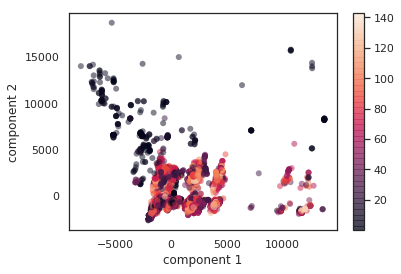

In [23]:
pca = PCA(2)  # project from 81 to 2 dimensions
projected = pca.fit_transform(features)
print(features.shape)
print(projected.shape)
plt.scatter(projected[:, 0], projected[:, 1],
            c=target, edgecolor='none', alpha=0.5,
            )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();